In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

from model_code.ADFA_model import *
from model_code.NGIDS_model import *
from model_code.Discriminator import *

from sklearn.model_selection import train_test_split
from model_code.ignite_trainer import MyTrainer


from collections import OrderedDict
import time


%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.curdir)))

cuda = torch.device('cuda') # GPU 사용

# hyper parameter

# gensim
word_vector_size = 20
window_size = 1

# LSTM
adfa_batch_size = 256
n_step = 3 # 1~3
n_hidden = 64 # 8~64
LearningRate = 0.01 # 0.01~0.001
max_epoch = 400
drop_out = 0.4 #0.2~0.5
patience = 20 

# ADDA
ngids_batch_size = 256
D_NGIDS_train_num = 1
adda_max_epoch = 50
adda_LearningRate = 0.0002

dates="6_20"

### Gensim 모델 구축


In [9]:
from model_code.ADFA_NGIDS_gensim import NGIDS_word2vec, ADFA_word2vec

NGIDS_word2vec_model = NGIDS_word2vec('./dataset/NGIDS_host_log_1-99.csv')
NGIDS_word2vec_model.make_vector(word_vector_size, save_path='./NGIDS_word2vec_'+str(word_vector_size)+'.model')

ADFA_word2vec_model = ADFA_word2vec('./dataset/ADFA-LD/')
ADFA_word2vec_model.make_vector(word_vector_size, save_path='./ADFA_word2vec_'+str(word_vector_size)+'.model')

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Gensim 모델 로드


In [2]:
import gensim

ADFA_word_model = gensim.models.Word2Vec.load('./ADFA_word2vec_'+str(word_vector_size)+'.model')
NGIDS_word_model = gensim.models.Word2Vec.load('./NGIDS_word2vec_'+str(word_vector_size)+'.model')

### 데이터 로드

In [3]:
def collate_fn(batch):

    x, y = zip(*batch)

    l = [len(i) for i in x]

    (l, i, t) = zip(*sorted(((l[i], i, (x[i], y[i])) for i in range(len(x))), reverse=True))
    (x, y) = zip(*t)

    l = torch.tensor(l)
    pack = nn.utils.rnn.pad_sequence(x, batch_first=True).to(cuda)
    y = torch.stack(y).to(cuda)

    return ((l, pack), y)

import pickle, gzip

slices = 111
X_train_add = "./shuffle_datas/ADFA_X_train_"+str(slices)+"_6_02.pkl"
y_train_add = "./shuffle_datas/ADFA_y_train_"+str(slices)+"_6_02.pkl"

X_vali_add = "./shuffle_datas/ADFA_X_vali_"+str(slices)+"_6_02.pkl"
y_vali_add = "./shuffle_datas/ADFA_y_vali_"+str(slices)+"_6_02.pkl"

X_test_add = "./shuffle_datas/ADFA_X_test_"+str(slices)+"_6_02.pkl"
y_test_add = "./shuffle_datas/ADFA_y_test_"+str(slices)+"_6_02.pkl"

def load_data(X_add, y_add):
    with gzip.open(X_add, 'rb') as f:
        X = pickle.load(f)
    with gzip.open(y_add, 'rb') as f:
        y = pickle.load(f)
    return X, y

def preprocess_y(y_data):
    label_dict = dict()
    for i in range(8):
        if i == 0:
            label_dict[i] = 0
        else:
            label_dict[i] = 1
#     tmp = np.argmax(y_data, axis=1)
    tmp = pd.Series(y_data).map(label_dict).values
    return np.asarray(tmp)

X_train, y_train = load_data(X_train_add, y_train_add)
X_vali, y_vali = load_data(X_vali_add, y_vali_add)
X_test, y_test = load_data(X_test_add, y_test_add)
y_train = preprocess_y(y_train)
y_vali = preprocess_y(y_vali)
y_test = preprocess_y(y_test)

ADFA_loader = DataLoader(ADFA_Dataset(X_train, y_train, ADFA_word_model.wv.key_to_index), 
                         batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)
ADFA_test_loader = DataLoader(ADFA_Dataset(X_test, y_test, ADFA_word_model.wv.key_to_index), 
                              batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)
ADFA_vali_loader = DataLoader(ADFA_Dataset(X_vali, y_vali, ADFA_word_model.wv.key_to_index), 
                              batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)

NGIDS_reader = NGIDS_Reader()
n_X_train, n_y_train, n_X_vali, n_y_vali, n_X_test, n_y_test = NGIDS_reader.data_split()

NGIDS_train_loader = DataLoader(NGIDS_Dataset(n_X_train, n_y_train, NGIDS_word_model.wv.key_to_index), 
                          batch_size=ngids_batch_size, collate_fn=collate_fn, shuffle = True)
NGIDS_vali_loader = DataLoader(NGIDS_Dataset(n_X_vali, n_y_vali, NGIDS_word_model.wv.key_to_index), 
                               batch_size=ngids_batch_size, collate_fn=collate_fn)
NGIDS_test_loader = DataLoader(NGIDS_Dataset(n_X_test, n_y_test, NGIDS_word_model.wv.key_to_index), 
                               batch_size=ngids_batch_size, collate_fn=collate_fn)

Training Results - Epoch[1]
Loss: 0.3299
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[1]
Loss: 0.3369
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[2]
Loss: 0.2655
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[2]
Loss: 0.2677
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[3]
Loss: 0.2376
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[3]
Loss: 0.2449
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[4]
Loss: 0.2327
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[4]
Loss: 0.2352
Accuracy: 0.8749
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[5]
Loss: 0.2143
Accuracy: 0.8753
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results -

Validation Results - Epoch[38]
Loss: 0.1690
Accuracy: 0.9437
Precision: 0.7135
Recall: 0.9195
ROC_AUC: 0.9333

Training Results - Epoch[39]
Loss: 0.0643
Accuracy: 0.9748
Precision: 0.8953
Recall: 0.9034
ROC_AUC: 0.9442

Validation Results - Epoch[39]
Loss: 0.1495
Accuracy: 0.9513
Precision: 0.8013
Recall: 0.8121
ROC_AUC: 0.8916

Training Results - Epoch[40]
Loss: 0.0563
Accuracy: 0.9776
Precision: 0.8925
Recall: 0.9326
ROC_AUC: 0.9583

Validation Results - Epoch[40]
Loss: 0.1500
Accuracy: 0.9505
Precision: 0.7961
Recall: 0.8121
ROC_AUC: 0.8912

Training Results - Epoch[41]
Loss: 0.0495
Accuracy: 0.9787
Precision: 0.8985
Recall: 0.9348
ROC_AUC: 0.9599

Validation Results - Epoch[41]
Loss: 0.1694
Accuracy: 0.9538
Precision: 0.7901
Recall: 0.8591
ROC_AUC: 0.9132

Training Results - Epoch[42]
Loss: 0.0438
Accuracy: 0.9807
Precision: 0.8966
Recall: 0.9551
ROC_AUC: 0.9697

Validation Results - Epoch[42]
Loss: 0.1610
Accuracy: 0.9547
Precision: 0.7914
Recall: 0.8658
ROC_AUC: 0.9166

Training 

2022-06-20 18:06:25,012 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[74]
Loss: 0.2684
Accuracy: 0.9530
Precision: 0.7719
Recall: 0.8859
ROC_AUC: 0.9242



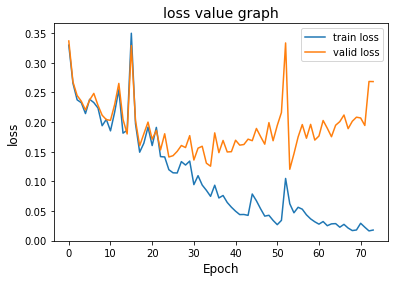

In [10]:
ADFA_model = nn.Sequential(OrderedDict([
            ('ADFA_LSTM', ADFA_LSTM(word_vector_size, ADFA_word_model.wv.vectors, n_hidden, n_step, dropout_p = drop_out)),
            ('ADFA_LINEAR', ADFA_LINEAR(n_hidden))
            ])).cuda()

optimizer = optim.Adam(ADFA_model.parameters(), lr=LearningRate)
loss_func = nn.CrossEntropyLoss() 

trainer = MyTrainer(ADFA_model, optimizer, loss_func, ADFA_loader, ADFA_vali_loader, patience)

trainer.run(max_epoch)


trainer.print_loss_graph("./result_image/lstm_weight_share_ADFA_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step))
torch.save(ADFA_model.state_dict(), "./lstm_weight_share_ADFA_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")


### 2번째 ADDA 단계 학습

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve


def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
def G_epoch_eval(G, ADFA_model, NGIDS_test_loader):
    
    ADFA_Classifier = ADFA_model.get_submodule('ADFA_LINEAR')

    G.eval()
    ADFA_Classifier.eval()

    
    model = nn.Sequential(G, ADFA_Classifier).cuda()

    TP = 0
    FP = 0
    FN = 0
    TN = 0

    labels = torch.tensor([]).to(cuda)
    outs = torch.tensor([]).to(cuda)

    with torch.no_grad():

         for iidx, i in enumerate(NGIDS_test_loader):
            batch_x, batch_y = i
            
            out = model(batch_x)
            
            labels = torch.concat((labels, batch_y))
            outs = torch.concat((outs, out))           

            for idx, j in enumerate(out) :

                if j[0] > j[1]:
                    result = 0
                else :
                    result = 1

                if batch_y[idx] == 1:
                    if result == 1:
                        TP += 1
                    else :
                        FN += 1                        
                else :
                    if result == 1 :
                        FP += 1
                    else :
                        TN += 1

#     labels = labels.detach().cpu().numpy()
#     outs = outs.detach().cpu().numpy()

#     try :
#         accuracy = (TP + TN)/(TP + FN + FP + TN)
#         recall = TP/(FN+TP)
#         precision = TP/(FP+TP)
#         f1= 2 * (precision * recall) / (precision + recall)
        
#         rascore = (roc_auc_score(labels, outs[:,0]) + roc_auc_score(labels, outs[:,1]))/2
#         fpr, tpr, thresholds = (roc_curve(labels, outs[:,0]) + roc_curve(labels, outs[:,1]))/2
        
#         plot_roc_curve(fpr, tpr)
        
#     except ZeroDivisionError :
#         accuracy = 0
#         recall = 0
#         precision = 0
#         rascore = 0
#         f1 = 0
#         pass
    
    accuracy = (TP + TN)/(TP + FN + FP + TN)
    recall = TP/(FN+TP)
    precision = TP/(FP+TP)
    f1= 2 * (precision * recall) / (precision + recall)

    print(f"Test accuacy : {accuracy}")
    print(f"Test Recall : {recall}")
    print(f"Test precision : {precision}")
    print(f"Test f1-score : {f1}")
#     print(f"Test ROC_AUC Score : {rascore}")
    
    return recall

In [5]:
ADFA_model = nn.Sequential(OrderedDict([
            ('ADFA_LSTM', ADFA_LSTM(word_vector_size, ADFA_word_model.wv.vectors, n_hidden, n_step, dropout_p = drop_out)),
            ('ADFA_LINEAR', ADFA_LINEAR(n_hidden))
            ]))

ADFA_model.load_state_dict(torch.load("./lstm_weight_share_ADFA_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model"))

ADFA_sub_model = ADFA_model.get_submodule('ADFA_LSTM')
ADFA_sub_model.eval()
ADFA_sub_model.cuda()

G = NGIDS_LSTM(word_vector_size, NGIDS_word_model.wv.vectors, n_hidden, n_step, adda_LearningRate, dropout_p = drop_out)
max_G = NGIDS_LSTM(word_vector_size, NGIDS_word_model.wv.vectors, n_hidden, n_step, adda_LearningRate, dropout_p = drop_out)

D = Discriminator(n_hidden, LearningRate = adda_LearningRate)
G.lstm.load_state_dict(ADFA_sub_model.lstm.state_dict())

G.cuda()
D.cuda()

G.train()
D.train()

torch.backends.cudnn.enabled = False

max_recall = -1

'''
G.load_state_dict(torch.load("./both_NGIDS_to_ADFA_"+str(word_vector_size)+"d_epoch"+'100'+"_ignite_"+dates+"_model.model"))
D.load_state_dict(torch.load("./both_Discriminator_"+str(word_vector_size)+"d_epoch"+'100'+"_ignite_"+dates+"_model.model"))
'''

loss_func = nn.CrossEntropyLoss()
d_optim = optim.Adam(D.parameters(), lr=adda_LearningRate)
g_optim = optim.Adam(G.parameters(), lr=adda_LearningRate)

d_losses = []
g_losses = []

n_iter = min(len(ADFA_loader), len(NGIDS_train_loader))

start_time = time.time()

for epoch in range(adda_max_epoch):
    print ("epoch = ", epoch + 1)
    
    source_iter = iter(ADFA_loader)
    target_iter = iter(NGIDS_train_loader)    
    
    d_loss_sum = 0
    g_loss_sum = 0
    
    for i in range(n_iter) :
        source_data, _ = next(source_iter)
        target_data, _ = next(target_iter)
        
        if len(source_data[0]) != len(target_data[0]):
               continue
        
        D_input_source = ADFA_sub_model(source_data)
        D_input_target = G(target_data)

        D_output_source = D(D_input_source)
        D_output_target = D(D_input_target)        
        
        D_target_source = torch.tensor([1] * len(source_data[0]), dtype=torch.long).cuda()
        D_target_target = torch.tensor([0] * len(source_data[0]), dtype=torch.long).cuda()

        D_output = torch.cat([D_output_source, D_output_target], dim=0)
        D_target = torch.cat([D_target_source, D_target_target], dim=0)
        
        d_loss = loss_func(D_output, D_target)
        
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        
        d_loss_sum += d_loss
        
        # target train
        D_input_target = G(target_data)
        D_output_target = D(D_input_target)
        
        g_loss = loss_func(D_output_target, D_target_source)
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
 
        g_loss_sum += g_loss
    

    d_loss = d_loss_sum / n_iter
    g_loss = g_loss_sum / n_iter
    
    d_losses.append(d_loss.detach().cpu())
    g_losses.append(g_loss.detach().cpu())
    
    print(f"D_loss : {d_loss:.4f} / G_loss : {g_loss:.4f}")
    recall = G_epoch_eval(G, ADFA_model, NGIDS_test_loader)
    
    end_time = time.time() - start_time
    print(f"Time(s): {end_time}")
    
    if max_recall < recall :
        max_recall = recall
        max_G.load_state_dict(G.state_dict())
        
    
torch.save(max_G.state_dict(), "./lstm_weight_NGIDS_to_ADFA_"+str(slices)+"_"+str(word_vector_size)+"d_epoch"+str(adda_max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")
torch.save(D.state_dict(), "./lstm_weight_Discriminator_"+str(slices)+"_"+str(word_vector_size)+"d_epoch"+str(adda_max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")

epoch =  1
D_loss : 0.6357 / G_loss : 0.6205
Test accuacy : 0.7868554829339143
Test Recall : 0.5268714011516314
Test precision : 0.13181272509003603
Test f1-score : 0.21086998271557517
Time(s): 130.51578211784363
epoch =  2
D_loss : 0.6142 / G_loss : 0.6304
Test accuacy : 0.7646021371511568
Test Recall : 0.5239923224568138
Test precision : 0.11900610287707061
Test f1-score : 0.19396092362344583
Time(s): 258.60987854003906
epoch =  3
D_loss : 0.5925 / G_loss : 0.6312
Test accuacy : 0.8021579001971159
Test Recall : 0.4884836852207294
Test precision : 0.13430079155672822
Test f1-score : 0.21067880794701985
Time(s): 386.28130531311035
epoch =  4
D_loss : 0.5704 / G_loss : 0.6285
Test accuacy : 0.8868139848532005
Test Recall : 0.2399232245681382
Test precision : 0.1524390243902439
Test f1-score : 0.18642803877703207
Time(s): 514.7655622959137
epoch =  5
D_loss : 0.5447 / G_loss : 0.6298
Test accuacy : 0.9223985890652557
Test Recall : 0.07869481765834933
Test precision : 0.13268608414239483


D_loss : 0.1449 / G_loss : 1.7343
Test accuacy : 0.6640211640211641
Test Recall : 0.5316698656429942
Test precision : 0.08467064037903102
Test f1-score : 0.14607778510217534
Time(s): 5155.4781284332275
epoch =  41
D_loss : 0.1391 / G_loss : 1.8631
Test accuacy : 0.6628799668015354
Test Recall : 0.5355086372360844
Test precision : 0.0848927430397079
Test f1-score : 0.1465528562048588
Time(s): 5285.0168697834015
epoch =  42
D_loss : 0.1292 / G_loss : 1.9624
Test accuacy : 0.6589895217346198
Test Recall : 0.5355086372360844
Test precision : 0.08393501805054152
Test f1-score : 0.14512353706111833
Time(s): 5414.197770118713
epoch =  43
D_loss : 0.1206 / G_loss : 2.0744
Test accuacy : 0.6536985164436144
Test Recall : 0.5431861804222649
Test precision : 0.08365356192728347
Test f1-score : 0.1449795081967213
Time(s): 5541.767021179199
epoch =  44
D_loss : 0.1136 / G_loss : 2.1812
Test accuacy : 0.6492374727668845
Test Recall : 0.6487523992322457
Test precision : 0.09558823529411764
Test f1-sco

In [10]:
# plt.plot(d_losses, label='d_loss')
# plt.legend()
# plt.xlabel('epoch', fontsize=12)
# plt.ylabel('loss', fontsize=12)
# plt.title("D loss value graph", fontsize=14)
# plt.show()

# plt.plot(g_losses, label='g_loss')
# plt.legend()
# plt.xlabel('epoch', fontsize=12)
# plt.ylabel('loss', fontsize=12)
# plt.title("G loss value graph", fontsize=14)
# plt.show()


In [ ]:
# import numpy as np
# from sklearn.metrics import roc_curve
# y = np.array([1, 1, 2, 2])
# scores = np.array([0.1, 0.8,0.9,0.8])

# plt.figure()
# lw = 2
# plt.plot(
#     fpr,
#     tpr,
#     color="darkorange",
#     lw=lw,
# )
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic example")
# plt.legend(loc="lower right")
# plt.show()

In [44]:
a = torch.rand(4,4)

In [45]:
print(a)

tensor([[0.8943, 0.5060, 0.6693, 0.4875],
        [0.6824, 0.1792, 0.5462, 0.6818],
        [0.8732, 0.7799, 0.2227, 0.2657],
        [0.9380, 0.8869, 0.4564, 0.1761]])


In [47]:
a, b =torch.max(a, 1)

In [75]:
a = np.array([ 1, 2, 3])
b = np.array([4, 3, 2])

a + b 

array([5, 5, 5])